### Import Libraries

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

### Define Physical Constants

In [7]:
c0 = 2.99792458e8  # Speed of light in vacuum (m/s)
eps0 = 8.854187817e-12  # Permittivity of free space (F/m)
mu0 = np.pi * 4e-7  # Permeability of free space (H/m)

### Setup Simulation Domain and Grid

In [8]:
L = 1.0  # Length of the rectangle (x-direction) in meters
W = 0.5  # Width of the rectangle (y-direction) in meters

# Spatial discretization
dx = 0.005  # Spatial step in x (m)
dy = 0.005  # Spatial step in y (m)
Nx = int(L / dx)  # Number of grid points in x
Ny = int(W / dy)  # Number of grid points in y

# Create grid coordinates for plotting
x_coords = np.linspace(0, L, Nx)
y_coords = np.linspace(0, W, Ny)
X, Y = np.meshgrid(x_coords, y_coords)

### Setup Time Discretization

In [9]:
# Courant-Friedrichs-Lowy (CFL) stability condition
# The time step must be small enough to ensure numerical stability
courant_number = 0.99
dt = courant_number / (c0 * np.sqrt((1/dx**2) + (1/dy**2)))

t_final = 100e-9  # Total simulation time in seconds (100 ns)
n_steps = int(t_final / dt)

### Define Material Properties

In [10]:
# Initialize material grids with free-space values
epsilon_r_map = np.ones((Nx, Ny))

# Define the dielectric square
diel_const = 13.1
diel_size = 0.20  # 20 cm side length

# Calculate the position of the dielectric in grid coordinates
diel_x_start = int((L / 2 - diel_size / 2) / dx)
diel_x_end = int((L / 2 + diel_size / 2) / dx)
diel_y_start = int((W / 2 - diel_size / 2) / dy)
diel_y_end = int((W / 2 + diel_size / 2) / dy)

# Assign the dielectric constant to the corresponding region
epsilon_r_map[diel_x_start:diel_x_end, diel_y_start:diel_y_end] = diel_const

### Initialize Field Arrays

In [11]:
# We are simulating a TMz wave, so we have Ez, Hx, and Hy components
Ez = np.zeros((Nx, Ny))
Hx = np.zeros((Nx, Ny))
Hy = np.zeros((Nx, Ny))

### Define the Current Source

In [12]:
# A Gaussian pulse is used for the current source for its smooth properties
source_x = int(0.1 / dx)  # 10 cm from the corner (0,0)
source_y = int(0.1 / dy)  # 10 cm from the corner (0,0)

# Gaussian pulse parameters
tau = 20 * dt
t0 = 6 * tau

### Pre-calculate Update Coefficients

In [13]:
# These coefficients are constant throughout the simulation
C_ez = dt / eps0
C_hx = dt / mu0
C_hy = dt / mu0

### Main FDTD Time-Stepping Loop

In [14]:
print("Starting FDTD simulation...")
for n in range(n_steps):
    # --- Update Hx field ---
    # Hx is updated using the curl of the Ez field
    # Hx(i, j) = Hx(i, j) - (dt / mu0) * (Ez(i, j+1) - Ez(i, j)) / dy
    Hx[:, :-1] -= C_hx * (Ez[:, 1:] - Ez[:, :-1]) / dy

    # --- Update Hy field ---
    # Hy is updated using the curl of the Ez field
    # Hy(i, j) = Hy(i, j) + (dt / mu0) * (Ez(i+1, j) - Ez(i, j)) / dx
    Hy[:-1, :] += C_hy * (Ez[1:, :] - Ez[:-1, :]) / dx

    # --- Update Ez field ---
    # Ez is updated using the curl of the H field
    # Ez(i, j) = Ez(i, j) + (dt / (eps0*eps_r)) * [ (Hy(i,j)-Hy(i-1,j))/dx - (Hx(i,j)-Hx(i,j-1))/dy ]
    Ez[1:-1, 1:-1] += (C_ez / epsilon_r_map[1:-1, 1:-1]) * \
        ((Hy[1:-1, 1:-1] - Hy[:-2, 1:-1]) / dx - \
         (Hx[1:-1, 1:-1] - Hx[1:-1, :-2]) / dy)

    # --- Inject the source current ---
    # The source is a Jz current density, which directly affects Ez
    current_t = np.exp(-((n * dt - t0) / tau)**2)
    Ez[source_x, source_y] -= (C_ez / epsilon_r_map[source_x, source_y]) * current_t

    # --- Apply PEC Boundary Conditions ---
    # For a PEC, the tangential electric field (Ez) must be zero.
    # This is enforced by ensuring the Ez values on the boundary are always zero.
    # Our update loop for Ez (from 1 to N-1) already avoids the boundaries,
    # effectively keeping them at their initial zero value.
    # Ez[0, :] = 0; Ez[Nx-1, :] = 0; Ez[:, 0] = 0; Ez[:, Ny-1] = 0;

    if (n + 1) % 1000 == 0:
        print(f"Step: {n+1}/{n_steps}, Time: {((n+1)*dt)*1e9:.2f} ns")

print("FDTD simulation finished.")

Starting FDTD simulation...
Step: 1000/8565, Time: 11.68 ns
Step: 2000/8565, Time: 23.35 ns
Step: 3000/8565, Time: 35.03 ns
Step: 4000/8565, Time: 46.70 ns
Step: 5000/8565, Time: 58.38 ns
Step: 6000/8565, Time: 70.05 ns
Step: 7000/8565, Time: 81.73 ns
Step: 8000/8565, Time: 93.40 ns
FDTD simulation finished.


### Plot the Results

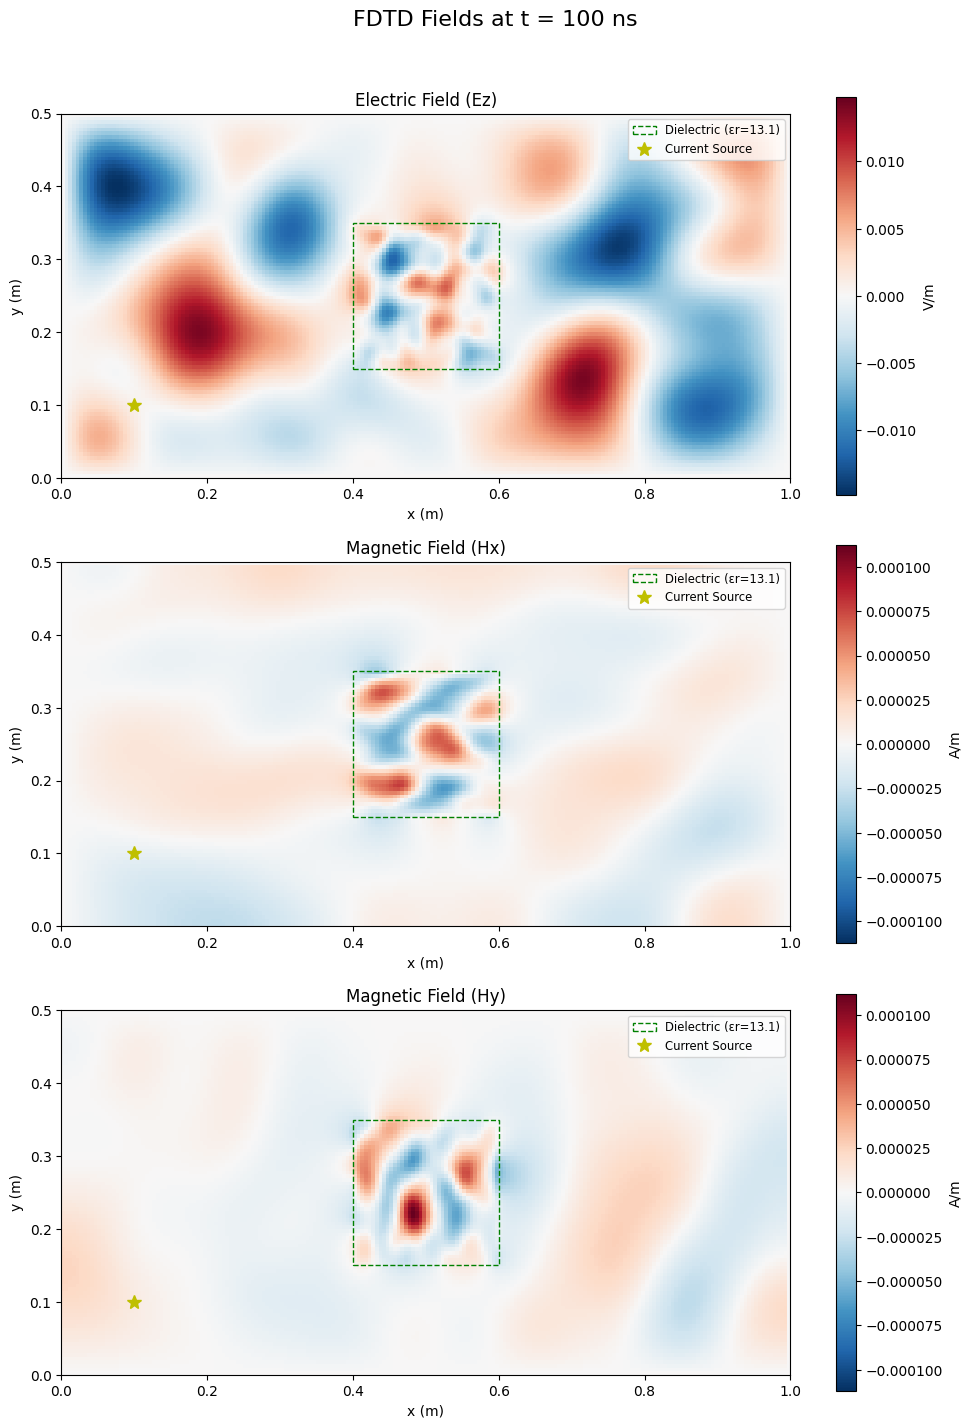

In [15]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
fig.suptitle(f'FDTD Fields at t = {t_final * 1e9:.0f} ns', fontsize=16)

# Find a common color scale limit for H fields
h_max = max(np.abs(Hx).max(), np.abs(Hy).max())
e_max = np.abs(Ez).max()

# Plot Ez field
ax1 = axes[0]
im1 = ax1.imshow(Ez.T, cmap='RdBu_r', origin='lower',
                 extent=[0, L, 0, W], vmin=-e_max, vmax=e_max)
ax1.set_title('Electric Field (Ez)')
ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')
fig.colorbar(im1, ax=ax1, label='V/m')

# Plot Hx field
ax2 = axes[1]
im2 = ax2.imshow(Hx.T, cmap='RdBu_r', origin='lower',
                 extent=[0, L, 0, W], vmin=-h_max, vmax=h_max)
ax2.set_title('Magnetic Field (Hx)')
ax2.set_xlabel('x (m)')
ax2.set_ylabel('y (m)')
fig.colorbar(im2, ax=ax2, label='A/m')

# Plot Hy field
ax3 = axes[2]
im3 = ax3.imshow(Hy.T, cmap='RdBu_r', origin='lower',
                 extent=[0, L, 0, W], vmin=-h_max, vmax=h_max)
ax3.set_title('Magnetic Field (Hy)')
ax3.set_xlabel('x (m)')
ax3.set_ylabel('y (m)')
fig.colorbar(im3, ax=ax3, label='A/m')

# Draw the dielectric and source position on all plots
for ax in axes:
    # Dielectric
    diel_patch = Rectangle((L/2 - diel_size/2, W/2 - diel_size/2),
                           diel_size, diel_size,
                           linewidth=1, edgecolor='g', facecolor='none',
                           linestyle='--', label='Dielectric (εr=13.1)')
    ax.add_patch(diel_patch)
    # Source
    ax.plot(source_x * dx, source_y * dy, 'y*', markersize=10, label='Current Source')
    ax.legend(loc='upper right', fontsize='small')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()